# **Cloudphysician's The Vital Extraction Challenge** 

## **Problem Statement:**
Patient monitoring is crucial in healthcare, as it allows healthcare professionals to closely track a patient's vital signs and detect any potential issues before they become serious. In particular, monitoring a patient's vitals, such as heart rate, blood pressure, and oxygen levels, can provide valuable information about a patient's overall health and well-being. The core problem statement is to extract *Heart Rate, SpO2, RR, Systolic Blood Pressure, Diabolic Blood Pressure, and MAP* from images of ECG Machines.


## **Proposed Pipeline:**
The proposed pipeline consists of a total of four stages. The whole pipeline is made such that it can work in two modes: **'Fast'** and **'Accurate**'. 
**By default, the pipeline is set to 'Accurate' mode**. 

The 'Fast' mode ensures that the whole pipeline runs under 2 seconds on CPU, while the 'Accurate’ mode ensures maximum accuracy at each stage, thus ensuring the best overall performance. 


 The four stages of the pipeline are as follows:


[![url](https://i.postimg.cc/k58kF1Bw/Untitled-Diagram-drawio-1.png)



1. Screen Extraction
2. Number Detection
3. OCR
4. Number Classification





# Downloading Libraries

In [1]:
%%capture
!pip install yolov5
!pip install paddlepaddle -qq
!pip install paddleocr -qq
!pip install ensemble-boxes -qq
!pip install timm
!pip install torchvision
!pip install pytorch_lightning
!pip install imutils

## Kindly Restart your Runtime after this cell, to execute them on your system

# Importing Libraries

In [36]:
!pip install segmentation-models-pytorch -qq

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import cv2

import torch
from torch import nn, optim
import torchvision.transforms as T
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import timm
import segmentation_models_pytorch as smp
import imutils
from skimage.transform import ProjectiveTransform

import os
from tqdm import tqdm
from PIL import Image
import albumentations as A
from sklearn.model_selection import train_test_split
import gc
import glob

import random
import yolov5
import paddleocr
from paddleocr import PaddleOCR,draw_ocr
from ensemble_boxes import *
import re
import torch.nn.functional as F
import copy
%matplotlib inline

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change root to your location
root = '/content/drive/MyDrive/InterIIT11MP/'

# Screen Extraction


The first stage of the pipeline is the extraction of monitor screens from the given images. We have approached the problem in two ways, which are as follows:
-  #### **Corner Regression**: 

    The Corner Regression approach uses a CNN encoder to regress on the values of the bounding boxes of the desired screen, thereby producing an output vector of length eight (x1,y1,x2,y2,x3,y3,x4,y4 - coordinates of the bounding box). The followings are the details of the training parameters and augmentations for the CNN:

   *  Model: **Fine-Tuned Resnet 34**
 * Augmentations: 

    We used a few custom augmentations in our pipeline because the standard libraries (e.g., Albumentations) do not provide augmentations on the random 4-sided polygon and are specifically tuned to rectangles. These custom augmentations improved the performance of our model and made it more robust.

    **Custom Horizontal Flip**: Our custom augmentation performs a horizontal flip on the image and accordingly changes the bounding box coordinates, even in non-rectangular cases for the newly flipped image.

    **Custom Random Crop**: Our custom implementation performs random crops to ensure that the full area of the screen is always visible in the augmented image. This random crop is implemented to mimic the scenarios where the model generally performs poorly (i.e., the original model performed poorly in images where the monitor was too close to the edge of the image). This augmentation significantly improved the model's performance on the edge cases, making it more robust to the actual scenarios.

    **RandomBrightnessContrast**: RandomBrightnessContrast from the Albumentations library for more robust training on various input image scenarios. 

**Loss: Mean Squared Error**

**Learning Rate: 0.001**

**Epochs: 30**

**Mean IoU: 0.873** 

* #### **UNet++ Semantic Segmentation**:

UNet++ takes the original image as input and mask as ground truth. We generated the ground truth mask from the given bounding box coordinates using the cv2.fillPoly function. The details of the training, preprocessing, and post-processing are as follows:

* Model: **UNET++ (from segmentation_models_pytorch)**
* Encoder: **resnext101_32x8d**
* Encoder weights: imagenet
* Augmentations:
    Except for the augmentations used in "Corner Regression," we used one more augmentation for training purposes: ShiftScaleRotate: translate, scale, and rotate the input. 
* Preprocessing:
    We use the same preprocessing as done on the original UNET++ pretraining. This normalizes the image to a distribution accustomed to the pre-trained weights.

**Epochs: 15**

**Learning Rate: 0.001**

**Mean IoU: 0.896**

**Loss: 0.75*Dice Loss + 0.25*BCE Loss**


We made a custom weighted loss for the training of UNET++. Dice Loss increases the intersection with the ground truth image, while BCE Loss ensures confidence in predictions. This weighted average of losses resulted in better overall learning of the model.








* #### **Area Union Fusion Ensembling**:
    We used the predicted boxes from Corner Regression (I) and UNET++ (II) to ensemble for final prediction. We used Area Union Prediction method, i.e, the largest polygon that covers both the predicted polygons, thus ensuring maximum coverage.

    ***Mean IoU Score: 0.91***





In [4]:
## Defining Corner Regression Model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('resnet34', pretrained=True, num_classes=768)
        self.ll = nn.Linear(768,8)
    
    def forward(self, img):
        x = self.model(img)
        x = self.ll(x)

        return x

model_reg = CNN()


## Define UNET++ Model

ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'imagenet'

model_unet = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1,
    in_channels=3,
    activation=None,
)

preprocessing_unet = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [7]:
## Loading weights

model_reg = model_reg.to(device)
model_unet = model_unet.to(device)

model_reg.load_state_dict(torch.load(root + '/weights/corner_reg.pt', map_location=device))
model_unet.load_state_dict(torch.load(root + '/weights/unet++_weights.pt', map_location=device))

<All keys matched successfully>

In [8]:
## Helper Functions

def get_preprocessing(preprocessing_fn):
    
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)


def to_tensor(x, **kwargs):
      
    return x.transpose(2, 0, 1).astype('float32')


def get_contour_from_mask(img):

    """
    Args:
        img (np.array): mask for which bounding box has to be formed
    Returns:
        cnr (np.array): corners of the bounding box
    """

    assert img.ndim == 2
    h, w = img.shape[:2]
    img = (img>0.9*img.max()) * 255
    img = np.ascontiguousarray(img, dtype=np.uint8)

    im_floodfill = img.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = img | im_floodfill_inv
    
    im_open = cv2.morphologyEx(np.uint8(im_out), cv2.MORPH_OPEN, np.ones((5, 5)),iterations= 5)
    image_sharp = cv2.morphologyEx(im_open, cv2.MORPH_CLOSE, np.ones((5, 5)),iterations= 5)

    cnts = cv2.findContours(image_sharp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    peri = cv2.arcLength(c, True)
    cnt = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    cnr = np.zeros((4,2))
    cnr[0] = cnt[(cnt[:,:,0] + cnt[:,:,1]).argmin()][0]
    cnr[1] = cnt[(cnt[:,:,0] - cnt[:,:,1]).argmax()][0]
    cnr[2] = cnt[(cnt[:,:,0] + cnt[:,:,1]).argmax()][0]
    cnr[3] = cnt[(cnt[:,:,1] - cnt[:,:,0]).argmax()][0]
    
    return cnr

def corner_regression(img_path, model, size = 224):

    """
    Args:
        img_path (str): path to the image
        model (torch.nn.Module): model for corner regression
        size (int): size of the image to be fed to the model
    Returns:
        corner_preds (np.array): corners of the bounding box of mask
    """
    
    model.eval()
    img_orig = cv2.imread(img_path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    img = A.Compose([A.Resize(size, size)])(image = img_orig)["image"]
    
    img = (np.transpose(img, (2, 0, 1))) / 255.0
    img = torch.tensor(img[np.newaxis,:,:,:])
    
    with torch.no_grad():
        corner_preds = model(img.to(device, dtype=torch.float32))
        
    corner_preds = corner_preds.detach().cpu().numpy()
    corner_preds = np.float32(corner_preds.reshape((4,2)))

    for pt in corner_preds:
        pt[0] = pt[0]/size * 1280.0
        pt[1] = pt[1]/size * 720.0

    width, height = 1280, 720
    target_corners = np.array([(0, 0), (width, 0), (width, height), (0, height)])
    
    H, _ = cv2.findHomography(corner_preds, target_corners, params=None)
    
    transformed_image = cv2.warpPerspective(
        img_orig, H, (img_orig.shape[1], img_orig.shape[0]))
    
    return corner_preds

def unet_prediction(img_path, model, preprocessing_fn, size = 320):

    """
    Args:
        img_path (str): path to the image
        model (torch.nn.Module): model for segmentation
        preprocessing_fn (callbale): data normalization function
        size (int): size of the image to be fed to the model
    Returns:
        corners (np.array): corners of the bounding box of mask
    """
    
    model.eval()
    im2 = np.array(Image.open(img_path))
    h, w, n = im2.shape
    true = im2.copy()
    resize_img = A.Compose([
            A.Resize(size, size)
        ])

    preprocessor = get_preprocessing(preprocessing_fn)
    
    im2 = resize_img(image = im2)['image']
    im = im2.copy()
    im2 = preprocessor(image = im2)['image']
    
    img = torch.tensor(im2)
    
    with torch.no_grad():
        out = model(img.unsqueeze(0).to(device, dtype = torch.float32))
        
    img = img.numpy()
    out = out.sigmoid().detach().cpu().numpy()
    temp = np.transpose(out.squeeze(0), [1,2,0]).copy()
    
    corners = get_contour_from_mask(np.uint8(temp*255).squeeze())
    
    for pt in corners:
        pt[0] = pt[0]/size * w*1.0
        pt[1] = pt[1]/size * h*1.0
        
    return corners

def min_max_corner_fusion(corner_unet, corner_reg):

    """
    Args:
        corner_unet (np.array): corners of the bounding box from segmentation
        corner_reg (np.array): corners of the bounding box from regression
    Returns:
        corner_min_max (np.array): corners of the bounding box from Min Max Corner Fusion Algorithm
    """
    
    corner_min_max = np.zeros((4,2))
        
    corner_min_max[0][0] = min(corner_unet[0][0], corner_reg[0][0])
    corner_min_max[0][1] = min(corner_unet[0][1], corner_reg[0][1])
    corner_min_max[1][0] = max(corner_unet[1][0], corner_reg[1][0])
    corner_min_max[1][1] = min(corner_unet[1][1], corner_reg[1][1])
    corner_min_max[2][0] = max(corner_unet[2][0], corner_reg[2][0])
    corner_min_max[2][1] = max(corner_unet[2][1], corner_reg[2][1])
    corner_min_max[3][0] = min(corner_unet[3][0], corner_reg[3][0])
    corner_min_max[3][1] = max(corner_unet[3][1], corner_reg[3][1])
    
    return corner_min_max

def screen_extraction(img_path, model_unet, model_reg, preprocessing_unet, mode = 'accurate'):

    """
    Args:
        img_path (str): path to the image
        model_unet (torch.nn.Module): unet model
        model_reg (torch.nn.Module): corner regression model
        preprocessing_unet (callbale): data normalization function of unet
        mode (str): mode of the algorithm
    Returns:
        transformed_image (np.array): transformed image
    """
    
    img = cv2.imread(img_path)
    
    if mode == 'accurate':
        
        corner_unet = unet_prediction(img_path, model_unet, preprocessing_unet)
        corner_reg = corner_regression(img_path, model_reg)
        corner_preds = min_max_corner_fusion(corner_unet, corner_reg)
        
    else:
        corner_preds = corner_regression(img_path, model_reg)
    
    for pt in corner_preds:
        pt[0] = pt[0]/img.shape[1] * 1280.0
        pt[1] = pt[1]/img.shape[0] * 720.0
        
        
    width, height = 1280, 720
    target_corners = np.array([(0, 0), (width, 0), (width, height), (0, height)])

    # Get matrix H that maps source_corners to target_corners
    H, _ = cv2.findHomography(corner_preds, target_corners, params=None)

    # Apply matrix H to source image.
    transformed_image = cv2.warpPerspective(
        img, H, (img.shape[1], img.shape[0]))
    
#     plt.imshow(transformed_image)
    
    return transformed_image

# Number Detection + OCR

After extracting the screens, our next stage in the pipeline is to find all the numbers on the screen and return the appropriate bounding boxes across them. This task is achieved with the help of two separate models: 
  
  - **YOLOv5** 
  - **PaddleOCR**
      
      * YOLOv5: 
              
          We trained YOLOv5 model for the detection of numbers on a screen. We assigned a “number” class to all given bounding box and then fine-tuned YOLO for the same. The details of training and hyperparameters are as follows:

          * Model: YOLOv5
          * Size: M
          * Epochs: 25
          * Learning Rate: 0.01 
          * Mean Inference time: 650 ms
          * Average Precision: 0.77

      * PaddleOCR:
              
         PaddleOCR is an optical character detection and recognition model implemented using PaddlePaddle (PArallel Distributed Deep LEarning) framework. In our pipeline, we have used Pre-trained PaddleOCR to detect numbers from the extracted screen. The details of the hyperparameters are as follows:
          * Recognition Algorithm: CRNN
          * Detection Algorithm: DB
          * Mean Inference Time: 2.5 s

    * Weighted Box Fusion of PaddleOCR and YOLO:
              
         Fine-tuned YOLOv5 is showing promising results on layouts it was trained on but a relatively low accuracy on unseen layouts. In any case, it was not giving any noise in the prediction. Pre-trained PaddleOCR captures boxes of all numbers on the screens, but being a text recognition model, it also predicts few noise in the screens, which is not required. Hence, we ensemble the predictions of both the models, using Weighted Box Fusion algorithm, taking the good points of both algorithms, thereby resulting in much more robust predictions.
      * Weighted Box Fusion algorithm utilizes confidence scores of all proposed bounding boxes to construct the averaged boxes. 

       * Mean Inference Time - 3.3 s






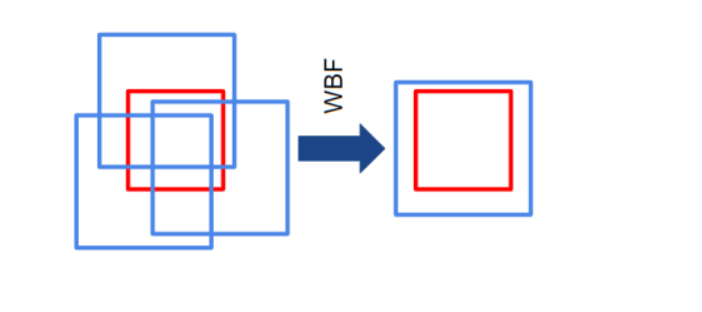


After getting all the bounding boxes around the numbers in the image, we use Optical Character Recognition to get the numbers written in the images. We implement this task using the ParSeq (Permuted AutoRegressive SEQuence) model. We are using the pre-trained model of ParSeq, and the details are as follows:

  * **Model: ParSeq**
  * **Accuracy: 0.95**
  * **Mean Inference Time: 1 s**


In [80]:
## Loading models for detection

yolo_model_det = yolov5.load(root + '/weights/final_yolo_weights.pt')
paddle_ocr_det_acc = PaddleOCR(cpu_threads=1, rec_batch_num=2, rec_algorithm='CRNN', rec_image_inverse=False)
model_ocr = torch.hub.load('baudm/parseq', 'parseq', pretrained=True).eval().to(device)
yolo_fast = yolov5.load(root + 'weights/yolo_on_6_fast.pt')
paddle_fast = PaddleOCR(use_angle_cls=False, lang='en', ocr_version = 'PP-OCR', structure_version = 'PP-Structure', 
                rec_algorithm = 'CRNN', max_text_length = 200, use_space_char = False, lan = 'en', det = False,
                cpu_threads = 12, cls = False,use_gpu=False )

[2023/02/07 18:56:15] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=1, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set=

Using cache found in /root/.cache/torch/hub/baudm_parseq_main


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_ppocr_mobile_v2.0_det_infer.tar to /root/.paddleocr/whl/det/en/en_ppocr_mobile_v2.0_det_infer/en_ppocr_mobile_v2.0_det_infer.tar


100%|██████████| 3.16M/3.16M [00:14<00:00, 219kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_number_mobile_v2.0_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_number_mobile_v2.0_rec_infer/en_number_mobile_v2.0_rec_infer.tar


100%|██████████| 2.70M/2.70M [00:13<00:00, 195kiB/s] 

[2023/02/07 18:56:50] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=12, crop_res_save_dir='./output', det=False, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5

In [62]:
yolo_model_det.eval();
model_ocr.eval();
yolo_fast.eval();

In [113]:
## Helper Functions
def return_fast_output(yolo_model, img):

    image = img.copy()

    results_yolo = yolo_model(img)

    try:
        boxes = results_yolo.pred[0][:, :4].tolist()
        scores = results_yolo.pred[0][:, 4].tolist()
        labels = results_yolo.pred[0][:, 5].tolist()
    except:
        boxes = []
        scores_yolo = []
        labels_yolo = []
    
    dic = {}
    for each in labels:
        if each not in dic.keys():
            dic[each] = (0,[])
    
    for i in range(len(labels)):
        score , box = dic[labels[i]]
        if score < scores[i]:
            dic[labels[i]] = (scores[i], boxes[i])
    
    # print(dic)
    return dic

def recognize_fast(image,dic,rec):

    vitals = {}
    labels = {0.0: 'DBP' , 1.0:'HR' , 2.0:'MAP', 3.0:'RR' ,4.0:'SBP' ,5.0:'SPO2' }
    for each in dic.keys():
        score, box = dic[each]
        xmin = int(box[0])
        xmax = int(box[2])
        ymin = int(box[1])
        ymax = int(box[3])
        img = image[ymin:ymax,xmin:xmax]
        text = rec.ocr(img,cls = False,det = False)[0][0][0]
        text = text.replace('(','').replace(')','').replace('/','').replace('-','').replace('*','')
        if text.isdigit():
            vitals[labels[each]] = text

    return vitals

def return_output(yolo_model, paddle_ocr, img):
  image = img.copy()
  results_yolo = yolo_model(img)
  try:
    boxes = results_yolo.pred[0][:, :4].tolist()
    scores_yolo = results_yolo.pred[0][:, 4].tolist()
    labels_yolo = results_yolo.pred[0][:, 5].tolist()
  except:
    boxes = []
    scores_yolo = []
    labels_yolo = []
  boxes_yolo = []
  for box in boxes:
    boxes_yolo.append([box[0]/1280, box[1]/720, box[2]/1280, box[3]/720])
  # results_paddle = paddle_ocr.ocr(img, cls=False, rec = True)
  # final_boxes_paddle = []
  # final_confidence_paddle = []
  # final_labels_paddle = [] 
  # for i in range(len(results_paddle[0])):
  #   xmin = results_paddle[0][i][0][0][0]/1280.
  #   ymin = results_paddle[0][i][0][0][1]/720.
  #   xmax = results_paddle[0][i][0][2][0]/1280.
  #   ymax = results_paddle[0][i][0][2][1]/720.
  #   temp = [xmin, ymin, xmax, ymax]

  #   # area
  #   if (xmax*1280 - xmin*1280)*(ymax*720 - ymin*720) < 1000:
  #     continue
    
  #   if (xmax*1280 - xmin*1280) < 120:
  #     continue
  #   if (xmax*1280 - xmin*1280) > 300:
  #     continue
  #   final_boxes_paddle.append(temp)
  #   final_confidence_paddle.append(results_paddle[0][i][1][1])
  # for i in range(len(final_confidence_paddle)):
  #   final_labels_paddle.append(0)
  result_box = boxes_yolo
  result_conf = scores_yolo
  result_label = labels_yolo
  return result_box, result_conf, result_label, img
  
################################################################################

def wbf_ensemble(boxes_list, scores_list, labels_list, image):
  weights = [2, 1]
  iou_thr = 0.6
  skip_box_thr = 0.01
  sigma = 0.1
  boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
  return boxes, scores

def recognize(image,boxes,scores):
    imgs = []
    for box in boxes:
        xmin = int(box[0]*1280)
        ymin = int(box[1]*720)
        xmax = int(box[2]*1280)
        ymax = int(box[3]*720)
        img = image[ymin:ymax,xmin:xmax]
        imgs.append(img)
    
    procs = [preproc_image(img) for img in imgs]
    preds = model_ocr(torch.cat(procs, dim=0))
    labels = inference_pred(preds)
    
    return labels,image,boxes,scores

def preproc_image(img):
    img = Image.fromarray(img).convert('RGB')
    transform = T.Compose([
            T.Resize((32, 128)),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])
    img = transform(img)
    return img.unsqueeze(0)

def inference_pred(pred):
    pred = pred.softmax(-1)
    label, _ = model_ocr.tokenizer.decode(pred)
    return label

In [88]:
def check_string(string):
  if(('(' in string or ')' in string) and '/' in string):
      return False
  elif (string.count('(') > 1 or string.count('/') > 1 or string.count(')') > 1):
      return False
  string = string.replace('(', '').replace('/', '').replace(')', '')
  pattern = r'^[\d]+$'
  return re.match(pattern, string) != None

#################


def image_dict(text , boxes , scores, image):
  c = 0
  text_l = []
  boxes_l = []
  scores_l = []

  for i, t in enumerate(text):
    if check_string(t):
      text_l.append(t)
      boxes_l.append(boxes[i])
      scores_l.append(scores[i])

  boxes_l, scores_l = np.array(boxes_l), np.array(scores_l)
  nums = np.array([float(txt.replace('(', '').replace('/', '').replace(')', '')) for txt in text_l])
  try:
    ind = np.argsort(scores_l)[-6:]
    scores_l = scores_l[ind]
    text_l = [text_l[x] for x in ind]
    boxes_l = boxes_l[ind]
    nums = nums[ind]
  except:
    pass
  boxes_dic = []
  for i,num in enumerate(text_l):
    bbxi = boxes_l[i]
    nm = nums[i]
    text_data = np.array([0.0, 0.0, 0.0])
    if '/' in num:
      text_data[0] = 1.0
    if '(' in num:
      text_data[1] = 1.0
    if ')' in num:
      text_data[2] = 1.0
    boxes_dic.append({'bbox': bbxi, 'num': nm, 'text_data': text_data})
    
  return {'image': image, 'val_vec': nums.tolist(), 'boxes': boxes_dic}

In [117]:
def number_detection(img, mode = 'accurate'):

  if mode == 'accurate':
    
    boxes, scores, result_label, img = return_output(yolo_model_det, paddle_ocr_det_acc, img)
    # result_box, result_conf, result_label, img = return_output(yolo_model_det, paddle_ocr_det_acc, img)

    # boxes, scores, img = wbf_ensemble(result_box, result_conf, result_label, img)

    text , img, boxes , scores = recognize(img, boxes,scores)

    number_dict = image_dict(text , boxes , scores, img)

  else:

    temp = return_fast_output(yolo_fast, img)

    number_dict = recognize_fast(img, temp, paddle_fast)

  return number_dict

# Number Classification

This task consists of classifying all the numbers detected by OCR into their respective classes. To implement this task, we have made **CRABBNet (Custom Recognition Assisted Bounding Box classification Network)**.  
  CRABBNet takes 3 inputs, a 4-channel Image, all numbers on the screen, and the target number which needs to be classified. 

  The working of CRABBNet is explained below:
  
  * The screen-extracted image (of 3 RGB channels) on which the prediction has to be made is concatenated with a 1-channel mask of the bounding box of the target number to produce a 4-channel input for the network.

  * This 4-channel input is passed to a ResNeXt - 50 model, which produces a 2048-length feature vector of the image. 
A 14-length vector is created, which contains information about all the numbers on the screen.

  * The 10 numbers in the vector denote the 10 numbers which are present on the screen. If less numbers are present, the remaining values are filled with 0
The next 3 numbers are binary values, indicating presence of ‘/’, ‘(‘ and ‘)’  in our target number which is to be classified. This is because, many a times in prediction of DBP and SBP, ‘/’ is seen in the image, while in prediction of MAP, ‘(‘ and ‘)’ are found.

* The last number of the vector is the target number itself.

* This 14-length vector is then passed to a linear layer, which converts this into 6-length vector. 
* This 6-length vector, is concatenated with the previous 2048-length feature vector, thereby resulting in 2054-length vector.
* This 2054-length vector is again concatenated with the target number, to give more weight to the target number, informing model to focus on predicting the target number.
* Hence, after this step, we would result in 2055-length vector.
This 2055-length vector is then passed again to a linear layer, with softmax activation, which gives probability of 6 classes among which the number would be present.

    * **Training Methodology**:
        * **Model : Resnext50_32x4d**
        * **Epochs : 15**
        * **Learning_rate : 0.001**
        * **Loss : CrossEntropy** 
        * **Accuracy :    77% (Out-of-fold Layout Validation) and 98% (Single Layout training)**







#### **Custom Logit-Decoder for Multi-label Matching**:

Using the above model we generate 6-class predictions for each bounding box on the screen. To combine predictions from multiple bounding boxes in multiple classes while ensuring single prediction for each vital, we use a customized probability decoder.


We use variance measure across each class prediction to get the most confident class and decide the box prediction for that class. This step is repeated on each class in the order of decreasing variance while simultaneously already selected bounding boxes to ensure a one-to-one mapping of bounding boxes and classes.


In [22]:
class CRABBNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes=0, in_chans=4)
        self.ll = nn.Linear(2048+7,6)
        self.fl = nn.Linear(14,6)
    
    def forward(self, img, text_data, num, val_vec):
        x = self.model(img)
        x = torch.cat([x, num.view(-1, 1), self.fl(torch.cat([num.view(-1, 1), text_data.view(-1, 3), val_vec.view(-1, 10)], dim=1))], dim=1)
        x = self.ll(x)
        x = x.view(-1, 6)
#         x = F.softmax(x, dim = 1)
        
        return x

In [24]:
model_crabb = CRABBNET()
model_crabb = model_crabb.to(device)
model_crabb.load_state_dict(torch.load(root + '/weights/crabbnet.pt', map_location = device))
model_crabb.eval();

In [118]:
class InferDataset(Dataset):
    def __init__(self, img_dict):
        super().__init__()
        
        self.img_dict = img_dict
                          
    def __getitem__(self, idx):
        img = self.img_dict['image']
        val_vec = np.array(self.img_dict['val_vec'])
        val_vec.resize(10,)
        np.random.shuffle(val_vec)
        
        boxes = self.img_dict['boxes'][idx]  
        bbox = boxes['bbox']
        
        xmin = int(bbox[0]*1280)
        ymin = int(bbox[1]*720)
        xmax = int(bbox[2]*1280)
        ymax = int(bbox[3]*720)

        mask = np.zeros((img.shape[0], img.shape[1], 1))
        mask = cv2.rectangle((mask), (xmin, ymin), (xmax, ymax), 255, -1)

        # plt.imshow(mask[:,:,0])
        # plt.show()
        
        num = boxes['num']
        text_data = boxes['text_data']

        img = cv2.resize(img, (224, 224))
        mask = cv2.resize(mask, (224,224))[:,:,None]
                
        arr4 = np.concatenate([img, mask], axis = 2)
                   
        arr4 = (np.transpose(arr4, (2, 0, 1))) / 255.0
        arr4 = torch.tensor(arr4)
        val_vec = torch.tensor(val_vec)
                
        return arr4, torch.tensor(num), torch.tensor(text_data), val_vec
    
    def __len__(self):
        return len(self.img_dict['boxes'])

########################

def pred_organizing(pred_mat, nums):
    num_boxes = nums.shape[0]
    box_store = set(range(num_boxes))
    mat_variance = torch.var(pred_mat, dim=0)
    argmax_dim0 = torch.argmax(pred_mat, dim=0)
    sorted_, indices = torch.sort(mat_variance, descending=True)
    
    res_dict = {'HR':None, 'RR':None, 'SPO2':None, 'SBP':None, 'DBP':None, 'MAP':None}
    label_cols = ['HR', 'RR', 'SPO2', 'SBP', 'DBP', 'MAP']
    
    for ind in indices:
        
        argmax_dim0 = torch.argmax(pred_mat, dim=0)
        box_ind = argmax_dim0[ind].item()

        if box_ind not in box_store:
            present = list(box_store)
            if len(present) == 0:
                continue
            
        res_dict[label_cols[ind]] = nums[box_ind]
        pred_mat[box_ind, :] = -100000
    
        if torch.unique(pred_mat).shape[0] == 1:
            break
    
    return res_dict

############################

def final_inference(img_dict):
    test_img = InferDataset(img_dict)

    test_loader = DataLoader(
            dataset=test_img,
            batch_size = len(img_dict['boxes']),
            num_workers = 0,
    )


    imgs, nums, text_data, val_vec = next(iter(test_loader))

    imgs = imgs.float()
    nums = nums.float()
    text_data = text_data.float()
    val_vec = val_vec.float()

    with torch.no_grad():
        label_preds = model_crabb(imgs, text_data, nums, val_vec)

    nums = nums.numpy()

    yerr_dict = pred_organizing(label_preds, nums)
    yerr_dict = {k:v for k,v in yerr_dict.items() if v is not None}

    return yerr_dict

#############################

# Final Inference

In [119]:
def vital_extraction(img_path, mode = 'accurate'):

  if mode == 'accurate':

    img = cv2.imread(img_path)
    transformed_image = screen_extraction(img_path, model_unet, model_reg, preprocessing_unet, mode)

    detection_dict = number_detection(transformed_image, mode)

    output_dict = final_inference(detection_dict)

    return output_dict

  else:
    
    img = cv2.imread(img_path)

    transformed_image = screen_extraction(img_path, model_unet, model_reg, preprocessing_unet, mode)

    detection_dict = number_detection(transformed_image, mode)

    return detection_dict